<a href="https://colab.research.google.com/github/MATHONSIMM/Data-Science-Group-Project/blob/main/APPL%20time%20series%20momentum%20approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict AAPL stock performance using the last five years of data from Yahoo Finance with a time series momentum approach.

In [1]:
pip install yfinance numpy pandas matplotlib scikit-learn

Step 1: Install Necessary Libraries

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf


Step 2: Fetch Data from Yahoo Finance

In [5]:
# Fetch AAPL stock data for the last 5 years
df = yf.download("AAPL", start="2018-01-01", end="2023-01-01")


[*********************100%***********************]  1 of 1 completed


Step 3: Calculate Momentum Features
Create lagged returns to capture momentum:

In [8]:
# Calculate daily returns
df['Return'] = df['Adj Close'].pct_change()

# Compute momentum features for 10, 25, 60, 120, 240 days
df['Ret10'] = df['Return'].rolling(10).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1/10) - 1))
df['Ret25'] = df['Return'].rolling(25).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1/25) - 1))
df['Ret60'] = df['Return'].rolling(60).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1/60) - 1))
df['Ret120'] = df['Return'].rolling(120).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1/120) - 1))
df['Ret240'] = df['Return'].rolling(240).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1/240) - 1))

# Drop NaN values
df = df.dropna()


Step 4: Define Target Variable
Set the target as the return over the next 25 days.

In [9]:
df['Target'] = df['Return'].shift(-25)  # Target: future 25-day return
df = df.dropna()  # Drop NaN rows


Step 5: Prepare Data for Machine Learning
Split features (X) and target (y) and create training and testing datasets.

In [10]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df[['Ret10', 'Ret25', 'Ret60', 'Ret120', 'Ret240']]
y = df['Target']

# Split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Squared Error: 0.0004759727962825413
R-squared: -0.018295890733734055


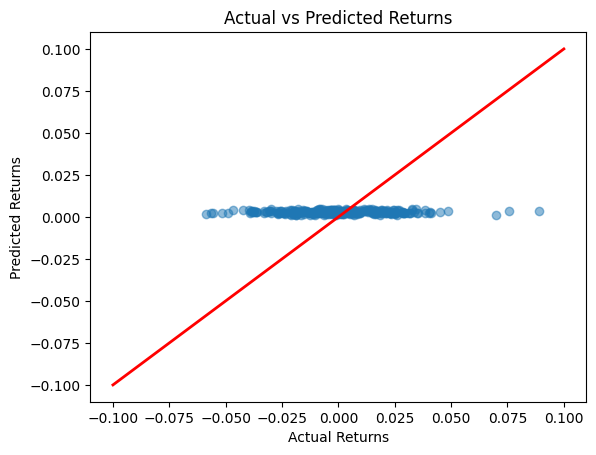

In [14]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color="red", linewidth=2)  # 45-degree line
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns")
plt.show()


In [15]:
# Initialize models
linear_model = LinearRegression()
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)


In [16]:
# List of models
models = {
    "Linear Regression": linear_model,
    "Random Forest": random_forest,
    "KNN": knn_model
}

# Cross-validation scores
scores = {}

for name, model in models.items():
    # Use Negative MSE as scoring, convert it to positive MSE later
    cv_scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
    mean_cv_mse = -np.mean(cv_scores)  # Convert to positive MSE
    scores[name] = mean_cv_mse

# Print results
for name, mse in scores.items():
    print(f"{name}: Mean MSE = {mse:.5f}")


Linear Regression: Mean MSE = 0.00047
Random Forest: Mean MSE = 0.00056
KNN: Mean MSE = 0.00055


In [17]:
# Training and evaluation
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "R-squared": r2}

# Print results
for name, metrics in results.items():
    print(f"{name}: Test MSE = {metrics['MSE']:.5f}, R-squared = {metrics['R-squared']:.5f}")


Linear Regression: Test MSE = 0.00048, R-squared = -0.01830
Random Forest: Test MSE = 0.00049, R-squared = -0.05897
KNN: Test MSE = 0.00053, R-squared = -0.13499


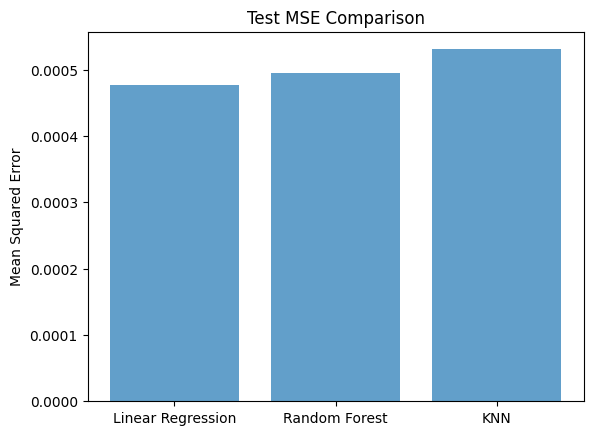

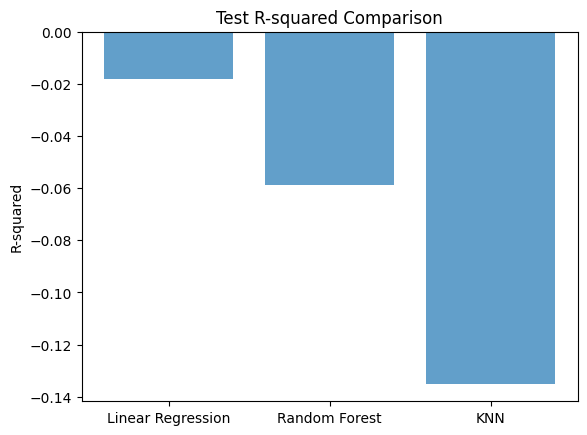

In [18]:
import matplotlib.pyplot as plt

# Bar plot for MSE comparison
model_names = list(results.keys())
mse_values = [results[name]["MSE"] for name in model_names]

plt.bar(model_names, mse_values, alpha=0.7)
plt.title("Test MSE Comparison")
plt.ylabel("Mean Squared Error")
plt.show()

# Bar plot for R-squared comparison
r2_values = [results[name]["R-squared"] for name in model_names]

plt.bar(model_names, r2_values, alpha=0.7)
plt.title("Test R-squared Comparison")
plt.ylabel("R-squared")
plt.show()
